In [1]:
# %% Cell 1: Install & Imports
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

# Install the latest segmentation-models from GitHub
!pip uninstall -y segmentation-models
!pip install git+https://github.com/qubvel/segmentation_models.git

import re, pickle
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import segmentation_models as sm
from glob import glob
import matplotlib.pyplot as plt

# Ensure segmentation-models uses tf.keras
sm.set_framework('tf.keras')
print('SM framework:', sm.framework())


Found existing installation: segmentation_models 1.0.1
Uninstalling segmentation_models-1.0.1:
  Successfully uninstalled segmentation_models-1.0.1
  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-9jtkctj5
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-9jtkctj5
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=cb8d4f8480aad0e8b0105c0e0642408974a91dcbd507339f2b374c0ab82e7bb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-7edgelf0/wheels/16/9b/76/6e33fba6f1888d8c6e0faf79bb28198229cb8dfab1a502558d
Successfully built segmentation_models
Segmentation Models: using `tf.keras` framework.
SM framework: tf.keras


In [2]:
# %% Cell 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# %% Cell 3: Callbacks & Resume Helpers
class EpochCheckpoint(Callback):
    """Save model and history after each epoch with unique names."""
    def __init__(self, save_dir, base_name):
        super().__init__()
        self.save_dir = save_dir
        self.base_name = base_name
        self.history_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        mpath = os.path.join(self.save_dir, f"{self.base_name}_{ep:02d}.h5")
        self.model.save(mpath)
        self.history_per_epoch.append(logs.copy() if logs else {})
        hpath = os.path.join(self.save_dir, f"history_{self.base_name}_{ep:02d}.pkl")
        with open(hpath, 'wb') as f:
            pickle.dump(self.history_per_epoch, f)

def find_last_checkpoint(save_dir, base_name):
    files = [f for f in os.listdir(save_dir) if re.match(f"{base_name}_\d+\.h5", f)]
    if not files:
        return None, None, 0
    epochs = [int(re.findall(r"(\d+)", f)[0]) for f in files]
    last = max(epochs)
    mpath = os.path.join(save_dir, f"{base_name}_{last:02d}.h5")
    hpath = os.path.join(save_dir, f"history_{base_name}_{last:02d}.pkl")
    return mpath, hpath, last


In [4]:
# %% Cell 4: Configuration & Data Pipeline
IMG_SIZE            = (224, 224)
BATCH_SIZE          = 16
DATA_DIR            = '/content/drive/MyDrive/dataset/plantvillage dataset/segmented'
SAVE_DIR            = '/content/drive/MyDrive/saved_models_segmented_prod'
os.makedirs(SAVE_DIR, exist_ok=True)
NUM_HEAD_EPOCHS     = 15
NUM_FINETUNE_EPOCHS = 50

def create_leaf_mask(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([25, 40, 40]); upper = np.array([85, 255, 255])
    mask = (cv2.inRange(hsv, lower, upper) > 0).astype('float32')
    return img/255.0, np.expand_dims(mask, -1)

def data_generator(img_paths, batch_size):
    idx = np.arange(len(img_paths))
    while True:
        np.random.shuffle(idx)
        for i in range(0, len(img_paths), batch_size):
            batch = idx[i:i+batch_size]
            X, Y = [], []
            for j in batch:
                x, y = create_leaf_mask(img_paths[j])
                X.append(x); Y.append(y)
            yield np.stack(X, axis=0), np.stack(Y, axis=0)

all_images = glob(os.path.join(DATA_DIR, '*', '*.jpg'))
split      = int(0.8 * len(all_images))
train_imgs = all_images[:split]
val_imgs   = all_images[split:]

train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_imgs, BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, *IMG_SIZE, 3), (None, *IMG_SIZE, 1))
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_imgs, BATCH_SIZE),
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, *IMG_SIZE, 3), (None, *IMG_SIZE, 1))
).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [5]:
# %% Cell 5: Build Model (Stage 1)
BACKBONE        = 'efficientnetb0'
ENCODER_WEIGHTS = 'imagenet'

model = sm.Unet(
    backbone_name   = BACKBONE,
    encoder_weights = ENCODER_WEIGHTS,
    input_shape     = (*IMG_SIZE, 3),
    classes         = 1,
    activation      = 'sigmoid',
    encoder_freeze  = True
)

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss      = sm.losses.bce_jaccard_loss,
    metrics   = [sm.metrics.iou_score]
)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 112, 112,  │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 112, 112,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 112, 112,  │          0 │ block2a_expand_b

 Total params: 10,115,501 (38.59 MB)

 Trainable params: 6,105,969 (23.29 MB)

 Non-trainable params: 4,009,532 (15.30 MB)

In [6]:
# %% Cell 6: Stage-1 Head Training
head_name = 'b0_head'
mp, hp, e0 = find_last_checkpoint(SAVE_DIR, head_name)
if mp:
    print(f'Resuming head training from epoch {e0}')
    model.load_weights(mp)

cb_head = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EpochCheckpoint(SAVE_DIR, head_name)
]

history1 = model.fit(
    train_ds,
    validation_data  = val_ds,
    steps_per_epoch  = len(train_imgs) // BATCH_SIZE,
    validation_steps = len(val_imgs)   // BATCH_SIZE,
    epochs           = e0 + NUM_HEAD_EPOCHS,
    initial_epoch    = e0,
    callbacks        = cb_head
)



Epoch 1/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - iou_score: 0.9314 - loss: 0.1302

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 9236s 3s/step - iou_score: 0.9314 - loss: 0.1302 - val_iou_score: 0.9785 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 2/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - iou_score: 0.9736 - loss: 0.0513

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 328s 109ms/step - iou_score: 0.9736 - loss: 0.0513 - val_iou_score: 0.9778 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 3/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - iou_score: 0.9781 - loss: 0.0425

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 304s 112ms/step - iou_score: 0.9781 - loss: 0.0425 - val_iou_score: 0.9824 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 4/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - iou_score: 0.9799 - loss: 0.0390

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 298s 110ms/step - iou_score: 0.9799 - loss: 0.0390 - val_iou_score: 0.9838 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 5/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - iou_score: 0.9815 - loss: 0.0359

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 296s 109ms/step - iou_score: 0.9815 - loss: 0.0359 - val_iou_score: 0.9836 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 6/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - iou_score: 0.9822 - loss: 0.0346

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 295s 109ms/step - iou_score: 0.9822 - loss: 0.0346 - val_iou_score: 0.9862 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 7/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - iou_score: 0.9831 - loss: 0.0327

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 291s 107ms/step - iou_score: 0.9831 - loss: 0.0327 - val_iou_score: 0.9865 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 8/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - iou_score: 0.9837 - loss: 0.0315

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 286s 106ms/step - iou_score: 0.9837 - loss: 0.0315 - val_iou_score: 0.9863 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 9/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9853 - loss: 0.0281

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 289s 106ms/step - iou_score: 0.9853 - loss: 0.0281 - val_iou_score: 0.9881 - val_loss: 0.0217 - learning_rate: 5.0000e-04
Epoch 10/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9853 - loss: 0.0282

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 275s 101ms/step - iou_score: 0.9853 - loss: 0.0282 - val_iou_score: 0.9882 - val_loss: 0.0212 - learning_rate: 5.0000e-04
Epoch 11/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9860 - loss: 0.0271

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 279s 103ms/step - iou_score: 0.9860 - loss: 0.0271 - val_iou_score: 0.9881 - val_loss: 0.0213 - learning_rate: 5.0000e-04
Epoch 12/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9862 - loss: 0.0266

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 274s 101ms/step - iou_score: 0.9862 - loss: 0.0266 - val_iou_score: 0.9888 - val_loss: 0.0211 - learning_rate: 5.0000e-04
Epoch 13/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9866 - loss: 0.0257

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 281s 104ms/step - iou_score: 0.9866 - loss: 0.0257 - val_iou_score: 0.9889 - val_loss: 0.0200 - learning_rate: 5.0000e-04
Epoch 14/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9865 - loss: 0.0259

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 281s 103ms/step - iou_score: 0.9865 - loss: 0.0259 - val_iou_score: 0.9877 - val_loss: 0.0234 - learning_rate: 5.0000e-04
Epoch 15/15
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - iou_score: 0.9870 - loss: 0.0251

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 275s 101ms/step - iou_score: 0.9870 - loss: 0.0251 - val_iou_score: 0.9895 - val_loss: 0.0188 - learning_rate: 5.0000e-04


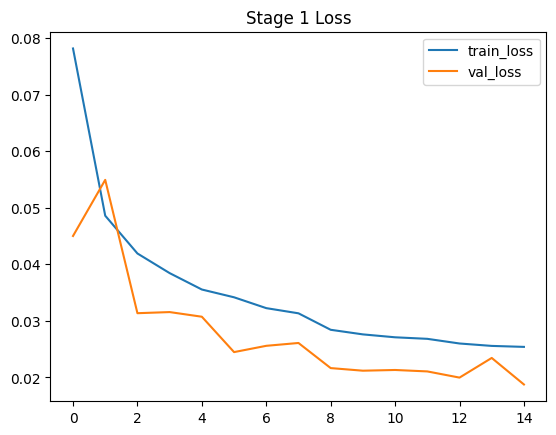

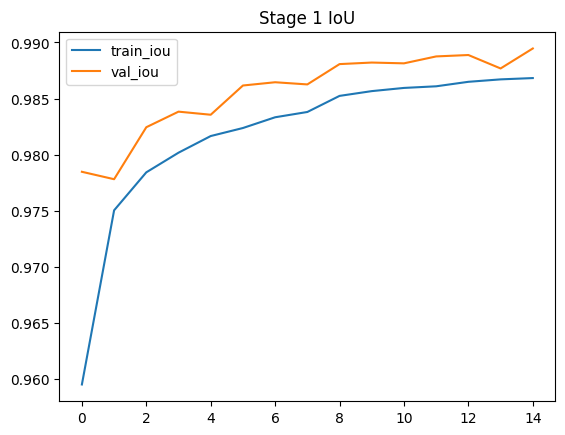

In [7]:
# %% Cell 7: Plot Stage-1 Metrics
def plot_history(hist, stage):
    plt.figure()
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{stage} Loss'); plt.legend()

    plt.figure()
    plt.plot(hist.history.get('iou_score', []), label='train_iou')
    plt.plot(hist.history.get('val_iou_score', []), label='val_iou')
    plt.title(f'{stage} IoU'); plt.legend()

plot_history(history1, 'Stage 1')


In [14]:
# %% Cell 8: Stage-2 Fine-Tuning
NUM_FINETUNE_EPOCHS=10
SAVE_DIR            = '/content/drive/MyDrive/saved_models_segmented_prodv1'

for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss      = sm.losses.bce_jaccard_loss,
    metrics   = [sm.metrics.iou_score]
)

fine_name = 'b0_finetune'
mp2, hp2, e1 = find_last_checkpoint(SAVE_DIR, fine_name)
if mp2:
    print(f'Resuming fine-tune from epoch {e1}')
    model.load_weights(mp2)

cb_ft = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EpochCheckpoint(SAVE_DIR, fine_name)
]

history2 = model.fit(
    train_ds,
    validation_data  = val_ds,
    steps_per_epoch  = len(train_imgs) // BATCH_SIZE,
    validation_steps = len(val_imgs)   // BATCH_SIZE,
    epochs           = e1 + NUM_FINETUNE_EPOCHS,
    initial_epoch    = e1,
    callbacks        = cb_ft
)


Epoch 1/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - iou_score: 0.9882 - loss: 0.0223

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 423s 124ms/step - iou_score: 0.9882 - loss: 0.0223 - val_iou_score: 0.9898 - val_loss: 0.0184 - learning_rate: 1.0000e-05
Epoch 2/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - iou_score: 0.9880 - loss: 0.0228

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 343s 115ms/step - iou_score: 0.9880 - loss: 0.0228 - val_iou_score: 0.9901 - val_loss: 0.0179 - learning_rate: 1.0000e-05
Epoch 3/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - iou_score: 0.9883 - loss: 0.0223

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 322s 119ms/step - iou_score: 0.9883 - loss: 0.0223 - val_iou_score: 0.9901 - val_loss: 0.0178 - learning_rate: 1.0000e-05
Epoch 4/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - iou_score: 0.9884 - loss: 0.0221

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 320s 118ms/step - iou_score: 0.9884 - loss: 0.0221 - val_iou_score: 0.9901 - val_loss: 0.0178 - learning_rate: 1.0000e-05
Epoch 5/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - iou_score: 0.9884 - loss: 0.0222

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 321s 118ms/step - iou_score: 0.9884 - loss: 0.0222 - val_iou_score: 0.9901 - val_loss: 0.0178 - learning_rate: 1.0000e-05
Epoch 6/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - iou_score: 0.9884 - loss: 0.0220

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 314s 116ms/step - iou_score: 0.9884 - loss: 0.0220 - val_iou_score: 0.9902 - val_loss: 0.0177 - learning_rate: 1.0000e-05
Epoch 7/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - iou_score: 0.9886 - loss: 0.0218

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 313s 115ms/step - iou_score: 0.9886 - loss: 0.0218 - val_iou_score: 0.9903 - val_loss: 0.0175 - learning_rate: 1.0000e-05
Epoch 8/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - iou_score: 0.9887 - loss: 0.0216

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 300s 110ms/step - iou_score: 0.9887 - loss: 0.0216 - val_iou_score: 0.9904 - val_loss: 0.0172 - learning_rate: 1.0000e-05
Epoch 9/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - iou_score: 0.9888 - loss: 0.0213

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 307s 113ms/step - iou_score: 0.9888 - loss: 0.0213 - val_iou_score: 0.9904 - val_loss: 0.0174 - learning_rate: 1.0000e-05
Epoch 10/10
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - iou_score: 0.9889 - loss: 0.0211

2715/2715 ━━━━━━━━━━━━━━━━━━━━ 301s 111ms/step - iou_score: 0.9889 - loss: 0.0211 - val_iou_score: 0.9906 - val_loss: 0.0170 - learning_rate: 1.0000e-05


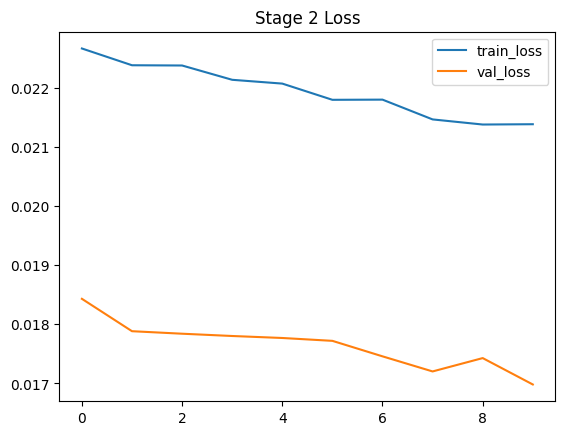

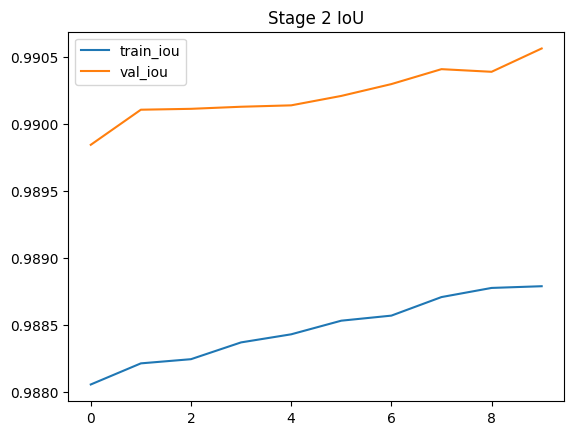

In [15]:
# %% Cell 9: Plot Stage-2 Metrics
plot_history(history2, 'Stage 2')